# FINE TUNING - LLAMA 3.2 17/05/2025

In [1]:
from transformers import AutoTokenizer, AutoModelForCausalLM, Trainer, TrainingArguments, DataCollatorForLanguageModeling
from peft import get_peft_model, LoraConfig, TaskType
from datasets import load_dataset
import torch
import pandas as pd
from sklearn.model_selection import train_test_split
from datasets import Dataset, DatasetDict
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline

In [5]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To log in, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add token as git credential? (Y/n) Y
Token is valid (permission: write).
The token `Competencia` has been saved to /root/.cache/huggingface/stored_tokens
Cannot authenticate through git-credential as no helper is defined on your machine.
You might have to re-authenticate wh

In [6]:
# === 1. Cargar modelo y tokenizer ===
model_name = "meta-llama/Llama-3.2-1B-Instruct"
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

tokenizer_config.json:   0%|          | 0.00/54.5k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/296 [00:00<?, ?B/s]

In [7]:
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype=torch.float16,
    device_map="auto"
)

config.json:   0%|          | 0.00/877 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.47G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/189 [00:00<?, ?B/s]

In [8]:
# === 2. Aplicar LoRA ===
lora_config = LoraConfig(
    r=16,
    lora_alpha=32,
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj"],
    lora_dropout=0.1,
    bias="none",
    task_type="CAUSAL_LM"
)

In [9]:
model = get_peft_model(model, lora_config)

In [10]:
model.print_trainable_parameters()

trainable params: 3,407,872 || all params: 1,239,222,272 || trainable%: 0.2750


In [11]:
# === 3. Dataset de ejemplo ===
df = pd.read_excel('Data_final.xlsx')
data = df[['ID', 'Texto', 'Categoria', 'Dataset']]
data.head()

,ID,Texto,Categoria,Dataset
0,1,"- ¡Rápido, necesitamos sangre! - Yo soy 0 posi...",Humor,test
1,2,- ¿Cuál es el mejor portero del mundial? - Ev...,Humor,train-val
2,3,El otro día unas chicas llamarón a mi puerta y...,Humor,test
3,4,"- Andresito, ¿qué planeta va después de Marte?...",Humor,train-val
4,5,- ¿Por qué Bob Esponja no va al gimnasio? - P...,Humor,train-val


In [12]:
# Mapear categorías a números
label_map = {"Humor": 1, "No Humor": 0}
data["label"] = data["Categoria"].map(label_map)
data.head(5)

,ID,Texto,Categoria,Dataset,label
0,1,"- ¡Rápido, necesitamos sangre! - Yo soy 0 posi...",Humor,test,1
1,2,- ¿Cuál es el mejor portero del mundial? - Ev...,Humor,train-val,1
2,3,El otro día unas chicas llamarón a mi puerta y...,Humor,test,1
3,4,"- Andresito, ¿qué planeta va después de Marte?...",Humor,train-val,1
4,5,- ¿Por qué Bob Esponja no va al gimnasio? - P...,Humor,train-val,1


In [13]:
# Seleccionar los datos de validación
test_df  = data.loc[data['Dataset'] =='test', ["Texto", "label"]].rename(columns={"Texto": "text"})
temp_df = data.loc[data['Dataset'] !='test', ["Texto", "label"]].rename(columns={"Texto": "text"})
# Dividir en train (82%), test (18%)
train_texts, val_texts, train_labels, val_labels = train_test_split(
    temp_df["text"], temp_df["label"], test_size=0.23, random_state=42, stratify=temp_df["label"]
)
train_df = pd.DataFrame({"text": train_texts, "label": train_labels})
val_df = pd.DataFrame({"text": val_texts, "label": val_labels})

In [14]:
# Reseteamos el índice
train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)
print(f"Entrenamiento: {train_df.shape}, Validación: {val_df.shape}, Prueba: {test_df.shape}")

Entrenamiento: (6976, 2), Validación: (2084, 2), Prueba: (2000, 2)


In [15]:
#Ejemplo
text = "¡Aprendiendo sobre Fine Tuning!"
tokenized_text = tokenizer.encode(text)

for token in tokenized_text:
    print(token, tokenizer.decode([token]))

128000 <|begin_of_text|>
40932 ¡
32 A
59976 prend
37116 iendo
15482  sobre
31253  Fine
28556  Tun
287 ing
0 !


In [16]:
# Convertir los DataFrames en objetos Dataset de la librería datasets
train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(val_df)
val_dataset = Dataset.from_pandas(test_df)

# Crear un DatasetDict con los conjuntos de datos
dataset = DatasetDict({
    'train': train_dataset,
    'validation': val_dataset,
    'test': test_dataset
})
# Ver la estructura
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 6976
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2084
    })
})


In [17]:
# === 4. Tokenización estilo generación causal ===
def tokenize_function(example):
    prompt = f"""Analiza el siguiente texto y clasifícalo ÚNICAMENTE con una de estas etiquetas:
    [humor], [no humor].

    Texto: "{example['text']}"

    Respuesta (solo la etiqueta, sin explicaciones):"""
    target = "[humor]" if example["label"] == 1 else "[no humor]"
    full_text = prompt + " " + target

    tokenized = tokenizer(
        full_text,
        padding="max_length",
        truncation=True,
        max_length=256
    )

    input_ids = tokenized["input_ids"]
    labels = input_ids.copy()

    # Enmascarar el prompt
    prompt_ids = tokenizer(prompt, truncation=True, max_length=256, add_special_tokens=False).input_ids
    prompt_len = len(prompt_ids)
    labels[:prompt_len] = [-100] * prompt_len

    return {
        "input_ids": input_ids,
        "attention_mask": tokenized["attention_mask"],
        "labels": labels
    }

tokenized_dataset = dataset.map(tokenize_function)

Map:   0%|          | 0/6976 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2084 [00:00<?, ? examples/s]

In [18]:
# === 5. DataCollator ===
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)

In [19]:
# === 6. Entrenamiento ===
training_args = TrainingArguments(
    output_dir="./lora-llama-humor",
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    eval_strategy="epoch",
    save_strategy="epoch",
    #logging_steps=10,
    num_train_epochs=2,
    learning_rate=2e-4,
    fp16=True,
    report_to="none",
    label_names=["label"],
    #save_total_limit=2,
)

In [20]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator
)

<ipython-input-20-2ee1f1e01b7e>:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [21]:
trainer.evaluate()

{'eval_loss': 3.3151469230651855,
 'eval_model_preparation_time': 0.0085,
 'eval_runtime': 76.9785,
 'eval_samples_per_second': 25.981,
 'eval_steps_per_second': 6.495}

In [22]:
trainer.train()

Epoch,Training Loss,Validation Loss,Model Preparation Time
1,1.539500,1.488331,0.008500
2,1.421100,1.471146,0.008500


TrainOutput(global_step=3488, training_loss=1.507742610546427, metrics={'train_runtime': 1465.0734, 'train_samples_per_second': 9.523, 'train_steps_per_second': 2.381, 'total_flos': 2.092781749980365e+16, 'train_loss': 1.507742610546427, 'epoch': 2.0})

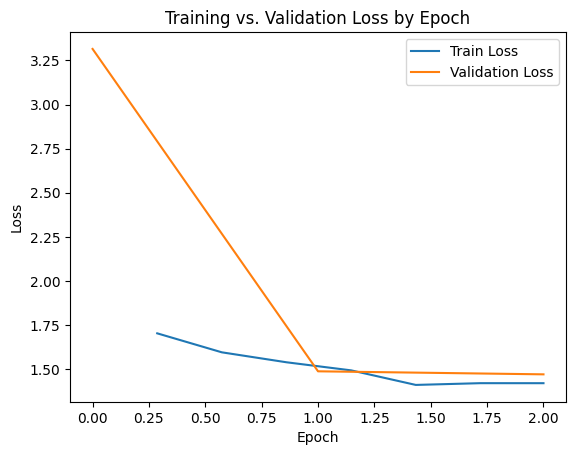

In [39]:
import matplotlib.pyplot as plt

logs = trainer.state.log_history
df = pd.DataFrame(logs)

# Filtrar los pasos en que hay pérdida de entrenamiento y de validación
train_df = df.dropna(subset=['loss', 'epoch'])
eval_df  = df.dropna(subset=['eval_loss', 'epoch'])

epoch_train = train_df.groupby('epoch')['loss'].mean().reset_index()
epoch_eval  = eval_df.groupby('epoch')['eval_loss'].last().reset_index()

new_row_train = pd.DataFrame({'epoch': [2.0], 'loss': [1.421]})
epoch_train = pd.concat([epoch_train, new_row_train], ignore_index=True)

new_row = pd.DataFrame({'epoch': [0.0], 'eval_loss': [3.315]})
epoch_eval = pd.concat([new_row, epoch_eval], ignore_index=True)

# Graficar
plt.figure()
plt.plot(epoch_train['epoch'], epoch_train['loss'], label='Train Loss')
plt.plot(epoch_eval['epoch'],  epoch_eval['eval_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs. Validation Loss by Epoch')
plt.legend()
plt.show()

In [42]:
# Clasificación mediante prompting
classifier = pipeline("text-generation", model=model, tokenizer=tokenizer)

def clasificar_humor(textos, classifier):
    resultados = []
    etiquetas_validas = {'humor', 'no humor'}

    prompt_template = """
    Analiza el siguiente texto y clasifícalo ÚNICAMENTE con una de estas etiquetas:
    [humor], [no humor].

    Texto: "{texto}"

    Respuesta (solo la etiqueta, sin explicaciones):""".strip()

    for texto in textos:
        try:
            # Generar prompt
            prompt = prompt_template.format(texto=texto[:3000])

            # Clasificación
            output = classifier(
                prompt,
                max_new_tokens=4,  # Suficiente para las etiquetas
                do_sample=False,
                temperature=0.0,  # Para mayor determinismo
                pad_token_id=50256  # Usar el pad token de LLaMA si es necesario
            )[0]["generated_text"]

            # Procesamiento robusto de la respuesta
            respuesta = output.replace(prompt, "").strip().lower()
            respuesta = respuesta.split()[0] if respuesta else ""

            # Validar y normalizar etiqueta
            etiqueta = "humor" if "humor" in respuesta else "no humor"

            resultados.append((etiqueta))

        except Exception as e:
            print(f"Error procesando texto: {texto[:50]}... - {str(e)}")
            resultados.append(("error"))

    return resultados

Device set to use cuda:0
The model 'PeftModelForCausalLM' is not supported for text-generation. Supported models are ['AriaTextForCausalLM', 'BambaForCausalLM', 'BartForCausalLM', 'BertLMHeadModel', 'BertGenerationDecoder', 'BigBirdForCausalLM', 'BigBirdPegasusForCausalLM', 'BioGptForCausalLM', 'BlenderbotForCausalLM', 'BlenderbotSmallForCausalLM', 'BloomForCausalLM', 'CamembertForCausalLM', 'LlamaForCausalLM', 'CodeGenForCausalLM', 'CohereForCausalLM', 'Cohere2ForCausalLM', 'CpmAntForCausalLM', 'CTRLLMHeadModel', 'Data2VecTextForCausalLM', 'DbrxForCausalLM', 'DeepseekV3ForCausalLM', 'DiffLlamaForCausalLM', 'ElectraForCausalLM', 'Emu3ForCausalLM', 'ErnieForCausalLM', 'FalconForCausalLM', 'FalconMambaForCausalLM', 'FuyuForCausalLM', 'GemmaForCausalLM', 'Gemma2ForCausalLM', 'Gemma3ForConditionalGeneration', 'Gemma3ForCausalLM', 'GitForCausalLM', 'GlmForCausalLM', 'Glm4ForCausalLM', 'GotOcr2ForConditionalGeneration', 'GPT2LMHeadModel', 'GPT2LMHeadModel', 'GPTBigCodeForCausalLM', 'GPTNeoFo

In [43]:
#Uso ejemplo:
textos = ["vendo casa", "¿Cómo se dice disparo en árabe? Ahí-va-la-bala."]
resultados = clasificar_humor(textos, classifier)

In [44]:
resultados

['no humor', 'humor']

In [45]:
import pandas as pd
df = pd.read_excel('Data_final.xlsx')
data = df[['ID', 'Texto', 'Categoria', 'Dataset']]
# Mapear categorías a números
label_map = {"Humor": 1, "No Humor": 0}
data["label"] = data["Categoria"].map(label_map)
# Seleccionar los datos de validación
test_df  = data.loc[data['Dataset'] =='test', ["Texto", "label"]].rename(columns={"Texto": "text"})
test_df = test_df.reset_index(drop=True)

In [46]:
textoss = test_df['text'].to_list()

In [47]:
resultados_1 = clasificar_humor(textoss, classifier)

/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:631: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:636: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


In [48]:
from collections import Counter
conteo = Counter(resultados_1)
print(conteo)

Counter({'humor': 1188, 'no humor': 812})


In [49]:
test_scores = test_df['label'].tolist()

In [50]:
label_map = {"humor": 1, "no humor": 0}
valores_numericos = [label_map[etiqueta] for etiqueta in resultados_1]

In [51]:
from sklearn.metrics import classification_report
print(classification_report(test_scores, valores_numericos))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99       804
           1       0.99      0.99      0.99      1196

    accuracy                           0.99      2000
   macro avg       0.99      0.99      0.99      2000
weighted avg       0.99      0.99      0.99      2000



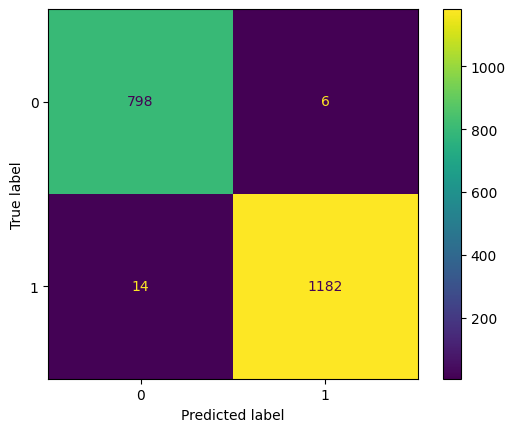

In [55]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(test_scores, valores_numericos)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [52]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [53]:
model = model.merge_and_unload()
model.save_pretrained("/content/drive/MyDrive/LLAMA-2-0.99-humor-finetuned-full")
tokenizer.save_pretrained("/content/drive/MyDrive/LLAMA-2-0.99-humor-finetuned-full")

('/content/drive/MyDrive/LLAMA-2-0.99-humor-finetuned-full/tokenizer_config.json',
 '/content/drive/MyDrive/LLAMA-2-0.99-humor-finetuned-full/special_tokens_map.json',
 '/content/drive/MyDrive/LLAMA-2-0.99-humor-finetuned-full/tokenizer.json')